In [3]:
import sys
import os
import orbslam2
import time
import cv2
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import ConnectionPatch
import numpy as np
import pykitti
import math
import glob
from eval.pose_evaluation_utils import *

ModuleNotFoundError: No module named 'eval'

In [ ]:
def toHomogeneous(coords):
    tmp = np.expand_dims(np.ones(len(coords)), axis=0)
    return np.concatenate((coords, tmp.T), axis=1)

def fromHomogeneous(coords):
    return np.array([np.array([p[0]/p[2], p[1]/p[2]]) for p in coords])

def get_inverse(mat):
    R = mat[0:3, 0:3].T
    t = mat[0:3, 3]
    t = -R @ t
    z = np.array([[0, 0, 0, 1]])
    tmp = np.concatenate((R, t.reshape(-1, 1)), axis=1)
    return np.concatenate((tmp, z), axis=0)

In [3]:
def plot_corr(img1, img2, img1_pts, img2_pts):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(211)
    ax1.imshow(img1, cmap='gray')
    ax1.scatter(img1_pts[:, 0], img1_pts[:, 1], marker='+')
    ax2 = plt.subplot(212)
    ax2.imshow(img2, cmap='gray')
    ax2.scatter(img2_pts[:, 0], img2_pts[:, 1], marker='+')

    for i in range(len(img1_points)):
        xy1 = (img1_pts[i,0],img1_pts[i,1])
        xy2 = (img2_pts[i,0],img2_pts[i,1])
        con = ConnectionPatch(xyA=xy2, xyB=xy1, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color='#53F242')
        ax2.add_artist(con)

    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()
    
    
def plot_img(img, pts, pts2=None):
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap='gray')
    plt.scatter(pts[:, 0], pts[:, 1], c='c', marker='+')
    if pts2 is not None:
        plt.scatter(pts2[:, 0], pts2[:, 1], c='red', marker='x')
    plt.show()

## ORB_SLAM 2
Define the ORB_SLAM 2 algorithm - this uses the python bindings since the ORB_SLAM code is originally written in C++. It takes a 'setting' file which contains the camera intrinsics files and other parameters for the ORB features. This algorithm can be used for the odometry or the raw dataset. 

This method returns 4 lists: `points`, `pose`, `inverse_pose`, `tframe`. 

`points`: 3D world points indexed by keyframe. So `points[3]` contains all points in the world that can be found in the 4th keyframe. 

`pose` & `inverse_pose`: 4x4 transformation matrices also indexed by the keyframe. 

`tframe`: the timestamps of all the keyframes used by ORB_SLAM. Since we have a list of _all_ frames with _all_ timestamps, these returned timestamps help determine which frames are keyframes. 

Example settings file: https://github.com/raulmur/ORB_SLAM2/blob/master/Examples/Monocular/KITTI04-12.yaml

In [4]:
def orbslam(imgs, timestamps, vocab, settings):
    num_images = len(imgs)
    
    slam = orbslam2.System(vocab, settings, orbslam2.Sensor.MONOCULAR)
    slam.set_use_viewer(False)
    slam.initialize()
    
    times_track = [0 for _ in range(num_images)]
    print('-----')
    print('Start processing sequence ...')
    print('Images in the sequence: {0}'.format(num_images))

    for idx in tnrange(num_images):
        image = cv2.imread(imgs[idx], cv2.IMREAD_UNCHANGED)
        tframe = timestamps[idx]

        if image is None:
            print("failed to load image at {0}".format(imgs[idx]))
            break

        t1 = time.time()
        slam.process_image_mono(image, tframe)
        t2 = time.time()

        ttrack = t2 - t1
        times_track[idx] = ttrack

        t = 0
        if idx < num_images - 1:
            t = timestamps[idx + 1] - tframe
        elif idx > 0:
            t = tframe - timestamps[idx - 1]

        if ttrack < t:
            time.sleep(t - ttrack)

    times_track = sorted(times_track)
    total_time = sum(times_track)
    print('-----')
    print('median tracking time: {0}'.format(times_track[num_images // 2]))
    print('mean tracking time: {0}'.format(total_time / num_images))
    
    tmp = np.expand_dims([0,0,0,1], axis=0)
    
    #convert pose and inverse pose into 4x4 matrices
    pose = np.array(slam.get_keyframe_poses())
    tframe = [t[0] for t in pose]
    pose = [np.concatenate((f[1:].reshape(3,4), tmp), axis=0) for f in pose]
    
    inverse_pose = np.array(slam.get_inverse_keyframe_poses())
    inverse_pose = [np.concatenate((f[1:].reshape(3,4), tmp), axis=0) for f in inverse_pose]
    points = [np.array(frame) for frame in slam.get_keyframe_points()]

    slam.shutdown()
    return points, pose, inverse_pose, tframe

In [5]:
def load_images(path_to_sequence):
    timestamps = []
    with open(os.path.join(path_to_sequence, 'times.txt')) as times_file:
        for line in times_file:
            if len(line) > 0:
                timestamps.append(float(line))

    return [
        os.path.join(path_to_sequence, 'image_0', "{0:06}.png".format(idx))
        for idx in range(len(timestamps))
    ], timestamps

## Exploring the Odometry Data Set

This small section explores the ORB SLAM algorithm used in the KITTI odometry dataset. By running the ORB_SLAM function we can test to see if the world points projected back into the frames make sense or not. 

In [6]:
BASE_DIR = "/Users/dewalgupta/Documents/ucsd/lab"
vocab_path = BASE_DIR + "/slam/pySLAM/Vocabulary/ORBvoc.txt"
settings_path = BASE_DIR + "/slam/pySLAM/Examples/Monocular/KITTI04-12.yaml"
sequence_path = BASE_DIR + "/data/KITTI/sequences/07"

image_filenames, timestamps = load_images(sequence_path)

In [7]:
points, pose, inverse_pose, tframe = orbslam(image_filenames, timestamps, vocab_path, settings_path)

-----
Start processing sequence ...
Images in the sequence: 1101



-----
median tracking time: 0.03137922286987305
mean tracking time: 0.033496465171931764


In [8]:
tframe_to_img = {}
for i in range(len(timestamps)):
    tframe_to_img[timestamps[i]] = image_filenames[i]

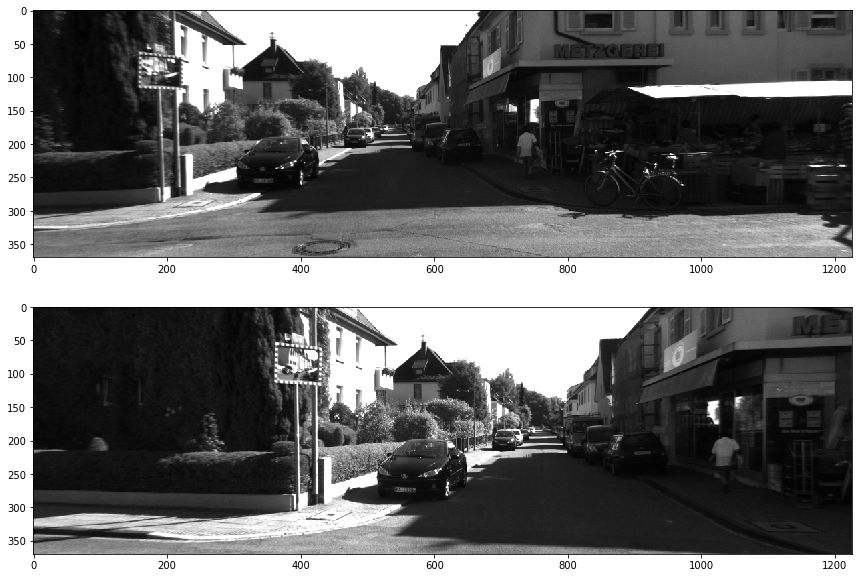

In [9]:
f1 = 0
f2 = 5
img1 = mpimg.imread(tframe_to_img[tframe[f1]])
img2 = mpimg.imread(tframe_to_img[tframe[f2]])

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.show()

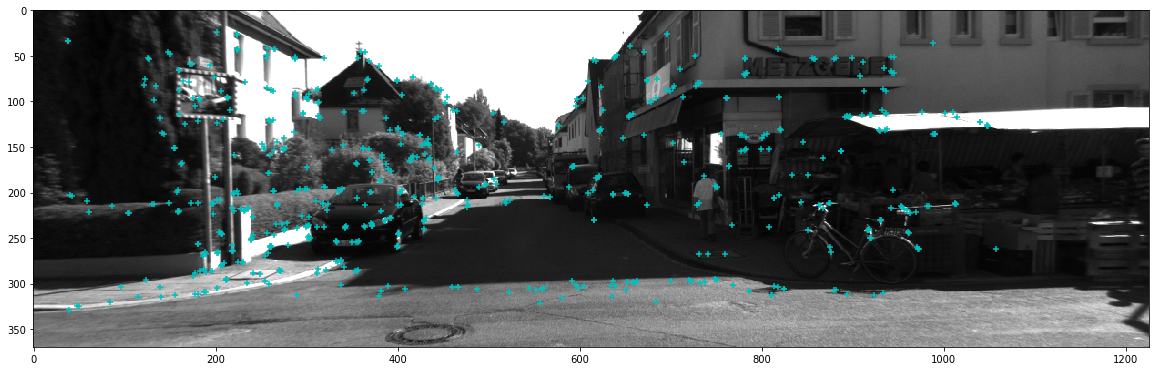

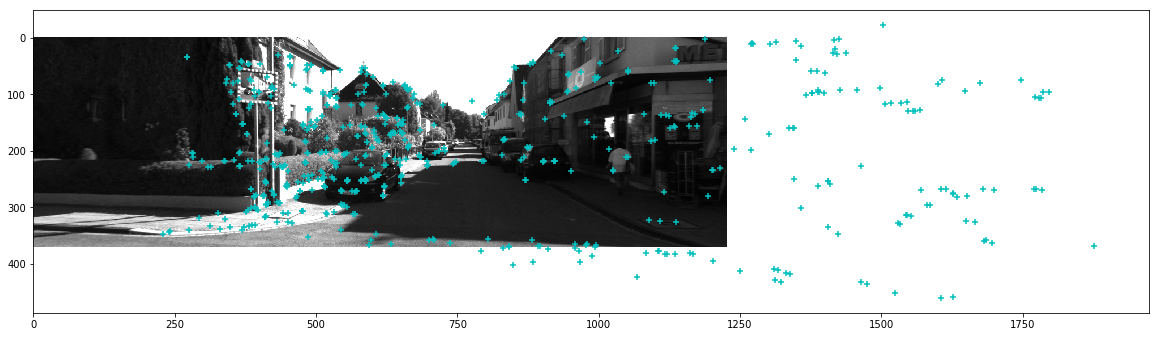

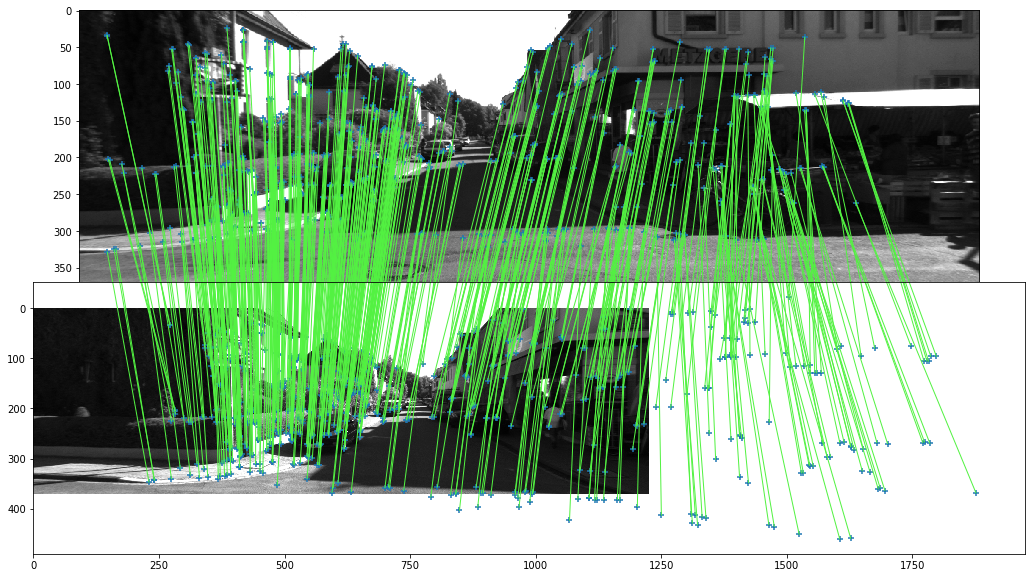

In [17]:
cx = 601.8873
cy = 183.1104
fx = 707.0912
fy = 707.0912

K = np.array([[fx, 0.0, cx, 0.0], 
              [0.0, fy, cy, 0.0], 
              [0.0, 0.0, 1.0, 0.0]])

Twc_f1 = K @ inverse_pose[f1]
Twc_f2 = K @ inverse_pose[f2]

img1_points = np.array([Twc_f1 @ p for p in world])
img2_points = np.array([Twc_f2 @ p for p in world])

img1_points = fromHomogeneous(img1_points)
img2_points = fromHomogeneous(img2_points)

plot_img(img1, img1_points)
plot_img(img2, img2_points)
plot_corr(img1, img2, img1_points, img2_points)

## Experimenting with KITTI raw dataset

This section uses the Raw dataset which provides IMU/OXT data as well. This data is used to determine the camera pose separately and compared to the ORB_SLAM poses to see if they match up (as they should).

#### ORB_SLAM

This first part looks at the poses and correspondances using the ORB_SLAM generated poses. 

In [8]:
BASE_DIR = '/Users/dewalgupta/Documents/ucsd/lab'
data_dir = BASE_DIR + '/data'
date = '2011_09_26'
drive = '0001'

data = pykitti.raw(data_dir, date, drive)

In [9]:
vocab_path = BASE_DIR + "/slam/pySLAM/Vocabulary/ORBvoc.txt"
settings_path = BASE_DIR + "/slam/pySLAM/Examples/Monocular/KITTI03.yaml"

timestamps = [t.timestamp() for t in data.timestamps]
orig_t = timestamps[0]
timestamps = [t - orig_t for t in timestamps]

In [12]:
points, pose, inverse_pose, tframe = orbslam(data.cam0_files, timestamps, vocab_path, settings_path)

-----
Start processing sequence ...
Images in the sequence: 108



-----
median tracking time: 0.03268909454345703
mean tracking time: 0.034701886000456636


In [28]:
tframe_to_img = {}
for i in range(len(timestamps)):
    tframe_to_img[timestamps[i]] = i
    
f1 = tframe_to_img[tframe[0]]
f2 = tframe_to_img[tframe[1]]

img1 = data.get_cam0(f1)
img2 = data.get_cam0(f2)

K = data.calib.P_rect_00
world = toHomogeneous(points[f1])

In [29]:
f1, f2

(0, 1)

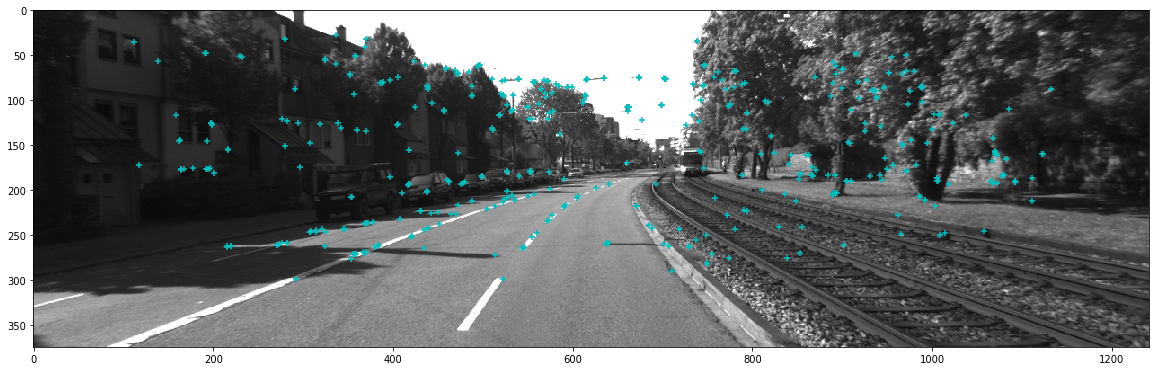

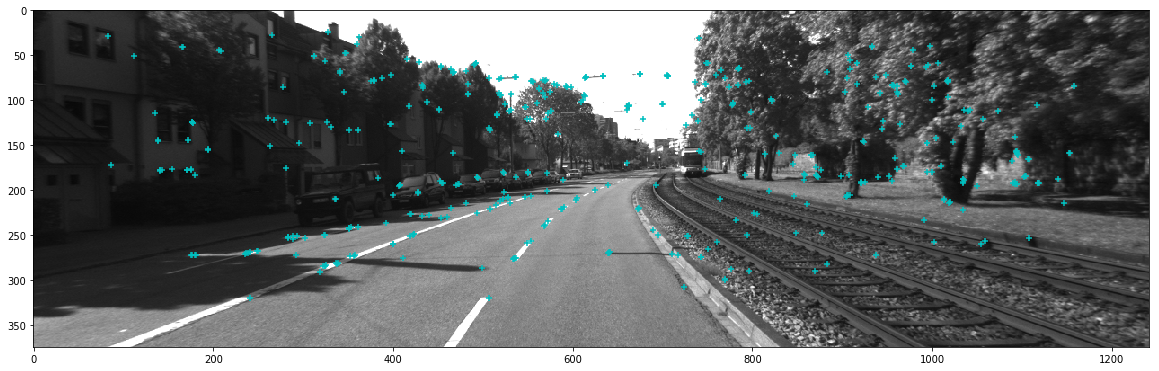

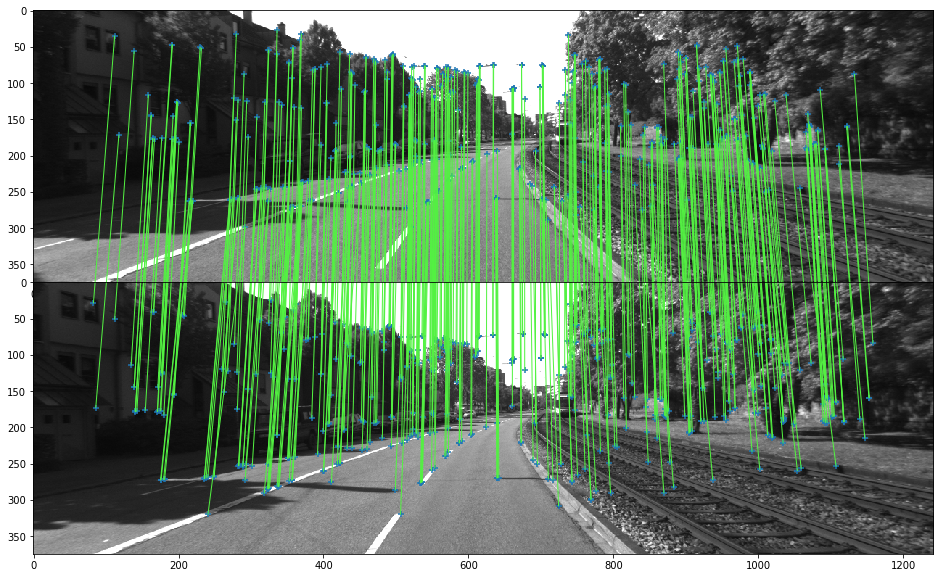

In [118]:
Twc_f1 = K @ inverse_pose[f1]
Twc_f2 = K @ inverse_pose[f2]

img1_points = np.array([Twc_f1 @ p for p in world])
img1_points = fromHomogeneous(img1_points)

img2_points = np.array([Twc_f2 @ p for p in world])
img2_points = fromHomogeneous(img2_points)

plot_img(img1, img1_points)
plot_img(img2, img2_points)
plot_corr(img1, img2, img1_points, img2_points)

#### IMU Data

This part uses the IMU data given as a part of the KITTI raw dataset to determine the poses. The poses are all calculated by the kitti dataset loader: https://github.com/utiasSTARS/pykitti/tree/master/pykitti

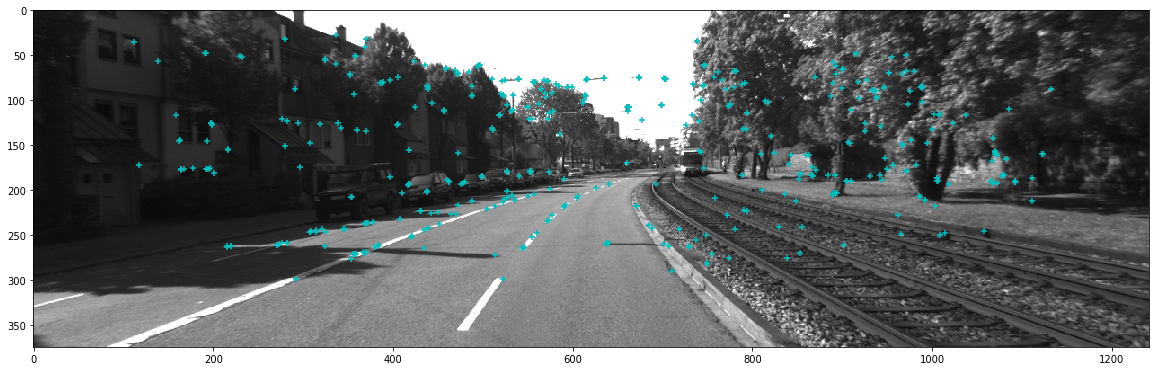

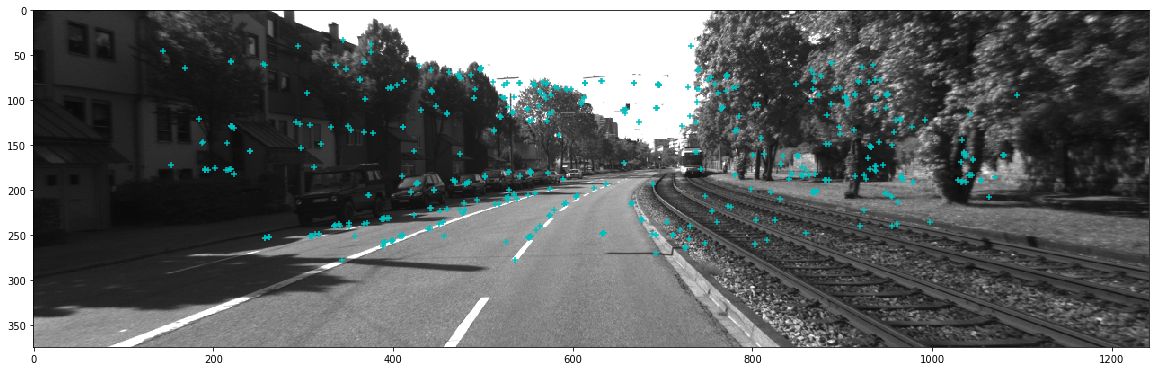

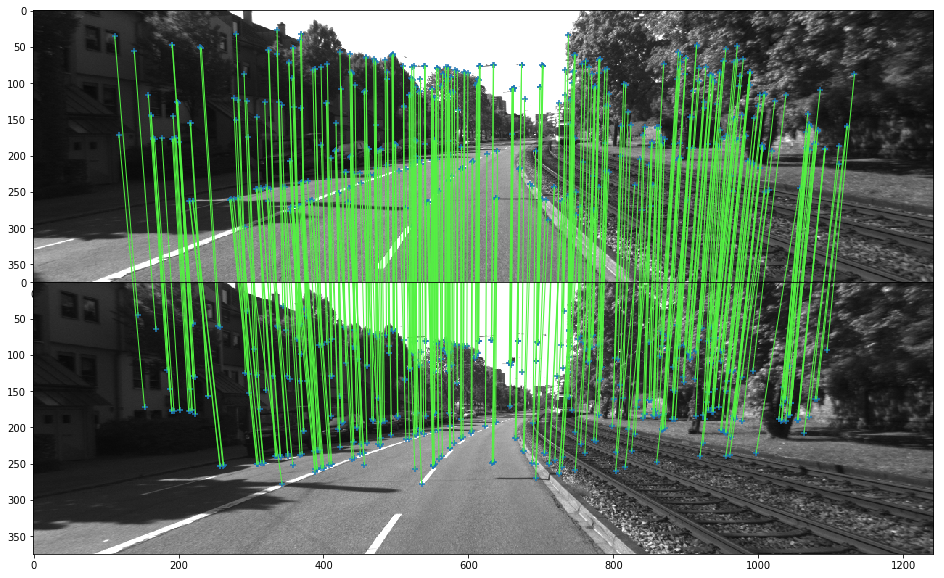

In [130]:
K_ci = data.calib.T_cam0_imu @ data.calib.R_rect_00
# K_ci = get_inverse(K_ci @ get_inverse(data.oxts[f1].T_w_imu)) @ K_ci

p1 = data.oxts[f1].T_w_imu
p2 = data.oxts[f2].T_w_imu

# odo_pose = imu2cam @ np.linalg.inv(data.oxts[0].T_w_imu) @ data.oxts[5].T_w_imu @ np.linalg.inv(imu2cam) # camera motion
rect_pose_f1 = K_ci @ get_inverse(p1) @ p1 @ get_inverse(K_ci)
rect_pose_f2 = K_ci @ get_inverse(p1) @ p2 @ get_inverse(K_ci)
rect_pose_f2[:, 3:4] /= -20

T_cw_f1 = K @ get_inverse(rect_pose_f1)
T_cw_f2 = K @ get_inverse(rect_pose_f2)
# T_cw_f2 = K @ inverse_pose[f2]

img1_points = np.array([T_cw_f1 @ p for p in world])
img1_points = fromHomogeneous(img1_points)

img2_points = np.array([T_cw_f2 @ p for p in world])
img2_points = fromHomogeneous(img2_points)

plot_img(img1, img1_points)
plot_img(img2, img2_points)
plot_corr(img1, img2, img1_points, img2_points)

In [73]:
print(data.calib.P_rect_00)

[[721.5377   0.     609.5593   0.    ]
 [  0.     721.5377 172.854    0.    ]
 [  0.       0.       1.       0.    ]]


In [65]:
K_ci = data.calib.T_cam0_imu
K_ci = data.calib.R_rect_00 @ K_ci @ get_inverse(data.oxts[f1].T_w_imu)
K_ci = get_inverse(K_ci @ get_inverse(data.oxts[f1].T_w_imu)) @ K_ci @ get_inverse(data.oxts[f2].T_w_imu)

print(K_ci)
print(inverse_pose[f2])

[[ 9.99997118e-01 -2.30428187e-03 -5.23317340e-04  1.23477312e+00]
 [ 2.30365601e-03  9.99996602e-01 -1.12247083e-03  7.45958528e-01]
 [ 5.25906476e-04  1.12126319e-03  9.99999210e-01 -4.61994659e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99997914e-01  7.15572503e-04 -1.90791511e-03  4.76664463e-05]
 [-7.13947811e-04  9.99999404e-01  8.52110621e-04 -5.62823152e-05]
 [ 1.90852373e-03 -8.50746699e-04  9.99997795e-01 -4.99792434e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [70]:
np.save('world_points.npy', points)
np.save('orb_poses.npy', pose)

## Re-Implementing the SFM-Learner Pose Experiments

This part runs the same experiments the SFM-Learner does using poses generated by ORB_SLAM full and short. Full orb_slam uses loop closure and bundle adjustment and uses all the frames in the sequence (aka unadulterated orb_slam). However, the short orb_slam is given only 5 frame windows and disables the loop closure features so it behaves more as a visual odometry system. Note: this is handled in the backend c++ code, so these changes will not be reflected in the code here and it might be slightly confusing as a result. 

The SFM-Learner splits all their trajectories into 5 window txt files and then the average error is reported. For the full orb_slam, we have to split the full trajectory ourselves since we are only given the poses with respect to the first frame. This is exactly what the `evaluate_seq` function seeks to do. 

For the short_orb slam, since we are only running orb with 5 frames, we do not need to rectify any poses, and can directly save these poses into their own text files that can be compared with the GT. 

The ground truth is taken from the SFM Learner data as they provide it. 

Another point of confusion: The GT contains poses for _all_ frame and timestamps. However, orb only returns poses for keyframes which may or may not span the entire 5 frame window. As a result sometimes the 5 frame window (for full or short orb_slam) may contain anywhere from 0-5 poses. These poses are scored using the SFM-Learner code with very few modificiations. They essentially align up the poses in the 5 frame window using the timestamps and evaluate the trajectory error between these aligned poses. 

In [15]:
# CONVENTION FOR QUATERNION: [qx, qy, qz, qw]
_EPS = np.finfo(float).eps * 4.0
def from_quaternion(quaternion):
    q = np.array(quaternion, dtype=np.float64, copy=True)
    n = np.dot(q, q)
    if n < _EPS:
        return np.identity(4)
    q *= math.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0-q[1, 1]-q[2, 2],     q[0, 1]-q[2, 3],     q[0, 2]+q[1, 3]],
        [    q[0, 1]+q[2, 3], 1.0-q[0, 0]-q[2, 2],     q[1, 2]-q[0, 3]],
        [    q[0, 2]-q[1, 3],     q[1, 2]+q[0, 3], 1.0-q[0, 0]-q[1, 1]]])

def to_quaternion(matrix, isprecise=False):
    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    if isprecise:
        q = np.empty((4, ))
        t = np.trace(M)
        if t > M[3, 3]:
            q[0] = t
            q[3] = M[1, 0] - M[0, 1]
            q[2] = M[0, 2] - M[2, 0]
            q[1] = M[2, 1] - M[1, 2]
        else:
            i, j, k = 1, 2, 3
            if M[1, 1] > M[0, 0]:
                i, j, k = 2, 3, 1
            if M[2, 2] > M[i, i]:
                i, j, k = 3, 1, 2
            t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
            q[i] = t
            q[j] = M[i, j] + M[j, i]
            q[k] = M[k, i] + M[i, k]
            q[3] = M[k, j] - M[j, k]
        q *= 0.5 / math.sqrt(t * M[3, 3])
    else:
        m00 = M[0, 0]
        m01 = M[0, 1]
        m02 = M[0, 2]
        m10 = M[1, 0]
        m11 = M[1, 1]
        m12 = M[1, 2]
        m20 = M[2, 0]
        m21 = M[2, 1]
        m22 = M[2, 2]
        # symmetric matrix K
        K = np.array([[m00-m11-m22, 0.0,         0.0,         0.0],
                         [m01+m10,     m11-m00-m22, 0.0,         0.0],
                         [m02+m20,     m12+m21,     m22-m00-m11, 0.0],
                         [m21-m12,     m02-m20,     m10-m01,     m00+m11+m22]])
        K /= 3.0
        # quaternion is eigenvector of K that corresponds to largest eigenvalue
        w, V = np.linalg.eigh(K)
        q = V[[0, 1, 2, 3], np.argmax(w)]
    if q[3] < 0.0:
        np.negative(q, q)
    return q

def quaternion_multiply(quaternion1, quaternion0):
    x0, y0, z0, w0 = quaternion0
    x1, y1, z1, w1 = quaternion1
    return np.array([x1*w0 + y1*z0 - z1*y0 + w1*x0,
                        -x1*z0 + y1*w0 + z1*x0 + w1*y0,
                         x1*y0 - y1*x0 + z1*w0 + w1*z0,
                        -x1*x0 - y1*y0 - z1*z0 + w1*w0], dtype=np.float64)

def quaternion_inverse(quaternion):
    q = np.array(quaternion, dtype=np.float64, copy=True)
    np.negative(q[:3], q[:3])
    return q / np.dot(q, q)

def dump_pose_seq_TUM(out_file, poses, times):
    # First frame as the origin
    first_pose = np.linalg.inv(poses[0])
    with open(out_file, 'w') as f:
        for p in range(len(times)):
            this_pose = poses[p]
            this_pose = first_pose @ this_pose
            tx = this_pose[0, 3]
            ty = this_pose[1, 3]
            tz = this_pose[2, 3]
            rot = this_pose[:3, :3]
            qx, qy, qz, qw = to_quaternion(rot)
    #         print('%f %f %f %f %f %f %f %f\n' % (times[p], tx, ty, tz, qx, qy, qz, qw))
            f.write('%s %f %f %f %f %f %f %f\n' % (times[p], tx, ty, tz, qx, qy, qz, qw))

def build_pose(R, t):
    z = np.array([[0, 0, 0, 1]])
    if len(t.shape) == 1:
        assert t.shape[0] == 3
        tmp = np.concatenate((R, np.expand_dims(t, 1)), axis=1)
        return np.concatenate((tmp, z), axis=0)
    
    if len(t.shape) == 2:
        l = []
        for i in range(t.shape[0]):
            tmp = np.concatenate((R[i], np.expand_dims(t[i], 1)), axis=1)
            l += [np.concatenate((tmp, z), axis=0)]
            
        return np.array(l)
    else:
        raise ValueError("wtf")
        
def eval(gt_dir, pred_dir):
    pred_files = glob.glob(pred_dir + '/*.txt')
    ate_all = []
    for i in range(len(pred_files)):
        gtruth_file = os.path.join(gt_dir, os.path.basename(pred_files[i]))
        
        if not os.path.exists(gtruth_file):
            print("Ground truth file not found!")
            print('\t> ground truth file: ' + gtruth_file)
            print('\t> pred file: ' + pred_files[i])
            continue
            
        ate = compute_ate(gtruth_file, pred_files[i])
        if ate == False:
            continue
        ate_all.append(ate)

    ate_all = np.array(ate_all)
#     print("Predictions dir: %s" % pred_dir)
    print("ATE mean: %.4f, std: %.4f" % (np.mean(ate_all), np.std(ate_all)))

In [225]:
def evaluate_seq(seq, overwrite=True):
    # Read the predicted paths files, and the ground truth files
    base = '/Users/dewalgupta/Documents/ucsd/lab/slam/eval/data/'

    gt_file = os.path.join(base, 'gt', seq + '_full.txt')
    gt_dir = os.path.join(base, 'gt', seq)

    res_file = os.path.join(base, 'results', seq + '_full.txt')
    path_to_save = os.path.join(base, 'results', seq)

    if not os.path.isdir(path_to_save):
        os.makedirs(path_to_save)
        overwite = True

    results = []
    with open(res_file) as f:
        results = f.readlines()
        results = [i.strip() for i in results]
        results = np.array([np.array(i.split(" "), dtype=np.float32) for i in results])

    res_times = results[:, 0]
    res_times = [str(round(t, 6)) for t in res_times]
    time_to_idx = {}
    for i in range(len(res_times)):
        time_to_idx[res_times[i]] = i

    t = results[:, 1:4]
    q = results[:, 4:]
    R = np.array([from_quaternion(i) for i in q])

    gt_times = []
    with open(gt_file) as f:
        gt_times = f.readlines()
        gt_times = [i.strip() for i in gt_times]
        gt_times = [str(round(float(i.split(" ")[0]), 6)) for i in gt_times]


    # Write out to txt files the 5 frames per window trajectory
    # SFM-learner looks at a window of 5 frames. This is determined by
    # the ground truth files which are also split up into 5 framed trajectories.
    # Each trajectory has its own txt file in the directory and the trajectory
    # is rectified so that the first item is the origin (and following frame's 
    # poses are adjusted so). 

    # For the predicted frames, we only have keyframes, so not every frame. Thus
    # we create trajectories where each timestamp starts as the first point. Again,
    # since we have fewer frames than the gt, we'll have fewer files. The file names,
    # however, are named as the same as GT. So for example, file 000045.txt for GT and 
    # prediction will both start at the same timestamp. If our preds contains poses
    # at other time stamps in 000045.txt in GT (since GT will always contain 5 poses), 
    # then we add those poses into our prediction 000045.txt. As a result, some of the
    # generated txt files will have 2 poses, and some will have all 5. Depends on which
    # times the keyframes were chosen. 

    if overwrite:
        for i in range(len(gt_times)-4):
        #     print(i, ": ", gt_times[i], ' to ', gt_times[i+4])
            poses = []
            times = []
            if gt_times[i] in time_to_idx:
                res_idx = time_to_idx[gt_times[i]]
                poses += [build_pose(R[res_idx], t[res_idx])]
                times += [gt_times[i]]

                for j in range(4):
                    if gt_times[i+j+1] in time_to_idx:
                        res_idx = time_to_idx[gt_times[i+j+1]]
                        poses += [build_pose(R[res_idx], t[res_idx])]
                        times += [gt_times[i+j+1]]

                fname = os.path.join(path_to_save, "%.6d.txt" % i)
        #         print( "%.6d.txt" % i, ": ", times)
                dump_pose_seq_TUM(fname, poses, times)
        
    eval(gt_dir, path_to_save)

In [223]:
evaluate_seq('09')

Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
ATE mean: 0.0145, std: 0.0084


In [226]:
evaluate_seq('10')

Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
Not enough matches.
ATE mean: 0.0123, std: 0.0115


In [48]:
# Make a few modifications to the ORB method to allow it to be run continuously without forcing it to 
# re-initialize and re-load the vocabulary since that takes a considerable amount of time. This is
# essentially the same algorithm as the one in the very beginning, but just more modular so it can be 
# called again and again without any extra loading costs.


def start_slam(vocab, settings):
    slam = orbslam2.System(vocab, settings, orbslam2.Sensor.MONOCULAR)
    slam.set_use_viewer(False)
    slam.initialize()
    return slam
    

def shutdown_slam(slam):
    slam.shutdown()
    
def orbslam_continuous(slam, imgs, timestamps):
    slam.reset()
    num_images = len(imgs)

    times_track = [0 for _ in range(num_images)]
#     print('-----')
#     print('Start processing sequence ...')
#     print('Images in the sequence: {0}'.format(num_images))

    for idx in range(num_images):
        image = cv2.imread(imgs[idx], cv2.IMREAD_UNCHANGED)
        tframe = timestamps[idx]

        if image is None:
            print("failed to load image at {0}".format(imgs[idx]))
            break

        t1 = time.time()
        slam.process_image_mono(image, tframe)
        t2 = time.time()

        ttrack = t2 - t1
        times_track[idx] = ttrack

        t = 0
        if idx < num_images - 1:
            t = timestamps[idx + 1] - tframe
        elif idx > 0:
            t = tframe - timestamps[idx - 1]

        if ttrack < t:
            time.sleep(t - ttrack)

    times_track = sorted(times_track)
    total_time = sum(times_track)
#     print('-----')
#     print('median tracking time: {0}'.format(times_track[num_images // 2]))
#     print('mean tracking time: {0}'.format(total_time / num_images))
    
    tmp = np.expand_dims([0,0,0,1], axis=0)
    
    #convert pose and inverse pose into 4x4 matrices
    pose = np.array(slam.get_keyframe_poses())
    tframe = [t[0] for t in pose]
    pose = [np.concatenate((f[1:].reshape(3,4), tmp), axis=0) for f in pose]
    
    inverse_pose = np.array(slam.get_inverse_keyframe_poses())
    inverse_pose = [np.concatenate((f[1:].reshape(3,4), tmp), axis=0) for f in inverse_pose]
    points = [np.array(frame) for frame in slam.get_keyframe_points()]

    return points, pose, inverse_pose, tframe

In [53]:
def run_orb_short(seq):
    BASE_DIR = '/Users/dewalgupta/Documents/ucsd/lab/'
    vocab_path = os.path.join(BASE_DIR, "slam/pySLAM/Vocabulary/ORBvoc.txt")
    settings_path = os.path.join(BASE_DIR, "slam/pySLAM/Examples/Monocular/KITTI04-12.yaml")
    sequence_path = os.path.join(BASE_DIR, "data/KITTI/sequences/", seq)
    path_to_save = os.path.join(BASE_DIR, 'slam/eval/data/orb_short/', seq)
    gt_dir = os.path.join(BASE_DIR, 'slam/eval/data/gt', seq)

    if not os.path.isdir(path_to_save):
        os.makedirs(path_to_save)

    image_filenames, timestamps = load_images(sequence_path)
    slam = start_slam(vocab_path, settings_path)

    for i in tnrange(len(timestamps)-4):
        times = [timestamps[i+t] for t in range(5)]
        imgs = [image_filenames[i+t] for t in range(5)]

        _, pose, _, tframe = orbslam_continuous(slam, imgs, times)

        if len(pose) == 0:
            continue

        fname = os.path.join(path_to_save, "%.6d.txt" % i)
        dump_pose_seq_TUM(fname, pose, tframe)

    shutdown_slam(slam)
    
    eval(gt_dir, path_to_save)

In [52]:
run_orb_short('09')

ATE mean: 0.0626, std: 0.1350


In [54]:
run_orb_short('10')

ATE mean: 0.0534, std: 0.1115
